In [64]:
import pandas as pd
import glob
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import bt_tools as bt

In [65]:
# add the atomic energy of the heavy atom and its hydrogens, e.g. E_C + 4* E_H for CH4
e_frags = []
for f in ['C', 'N', 'O', 'F']:
    e = np.loadtxt(f'/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/sat_frags/{f}/atomic_energies_sat_frag.txt', skiprows=1)
    e_frags.append(e[:,-1].sum())
    
e_frags = dict(zip(['C', 'N', 'O', 'F'] , e_frags))

# atomic energy of hydrogen in H2
e_H2 = (-1.029154884995695962e+00+-1.029154960269883290e+00)/2

comps = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
energies = []

for c in comps:
    file = f'/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/diatomics/{c}/binding_energy.txt'
    with open(file, 'r') as f:
        f.readline()
        e = []
        Z = []
        

        for line, el in zip(f, c):
            Z.append(float(line.strip('\n').split()[0]))
            # atomic energy of heavy atom in diatomic plus atomic energy of attached hydrogens + 0.5 atomic energy of H in H2 
            # - atomic energy of heavy atom in saturated fragment including atomic energy of attached hydrogens
            e.append(float(line.strip('\n').split()[2])+e_H2-e_frags[el])
        if Z[0] == Z[1]:
            energies.append([Z[0], Z[0], (e[0]+e[1])/2])
        else:
            energies.append([Z[0], Z[1], e[0]])
            energies.append([Z[1], Z[0], e[1]])
            
energies = np.array(energies)

# for each diatomic there are two energies
# e.g. H3CNH2:
# 6,7: energy of carbon fragment ( as defined above)
# 7, 6: energy of nitrogen fragment
# the sum of these energies is the reaction energy for the isodesmic reaction: H3CNH2 + H2 -> CH4 + NH3

binding_data = pd.DataFrame(energies, columns=['ZA', 'ZB', 'EA'])

In [66]:
binding_data

,ZA,ZB,EA
0,6.0,6.0,-5.594561
1,6.0,7.0,-5.952381
2,7.0,6.0,-5.616472
3,6.0,8.0,-6.296449
4,8.0,6.0,-5.487414
5,6.0,9.0,-6.502801
6,9.0,6.0,-5.404629
7,7.0,7.0,-5.969523
8,7.0,8.0,-6.282718
9,8.0,7.0,-5.908066


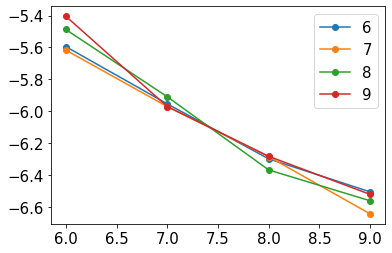

In [67]:
# the energy of the fragment energy as function of the binding partner
for Z in range(6, 10):
    plt.plot(binding_data.loc[binding_data['ZA']==Z, 'ZB'], binding_data.loc[binding_data['ZA']==Z, 'EA'], '-o', label = Z)
plt.legend()

Error in kcal/mol = 29.369425901347082


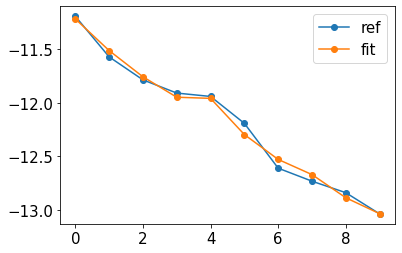

In [68]:
# linear model with isodesmic fragment energies
ZA = []
ZB = []
for i in range(6, 10):
    for j in range(i, 10):
        ZA.append(i)
        ZB.append(j)
xdata = np.array((ZA, ZB)).T

# construct BDE opbject
mat_gen = bt.BDE_clean(0,0,0,0, ZA, ZB, xdata)
coeff_mat = mat_gen.get_coeff_mat()

# sum of fragment energies = reaction energy for isodesmic reaction
binding_energies = []
for za, zb in xdata:
    EA = binding_data.loc[(binding_data['ZA'] == za) & (binding_data['ZB']==zb), 'EA'].item()
    EB = binding_data.loc[(binding_data['ZA'] == zb) & (binding_data['ZB']==za), 'EA'].item()
    binding_energies.append(EA+EB)
# linear model
a,b,c,d = np.linalg.lstsq(coeff_mat, binding_energies, rcond=None)
bef = a@coeff_mat.T # fitted energies

plt.plot(binding_energies, '-o', label = 'ref')
plt.plot(bef, '-o', label = 'fit')
plt.legend()
print('Error in kcal/mol = ' + str(np.abs(binding_energies-bef).mean()*630))

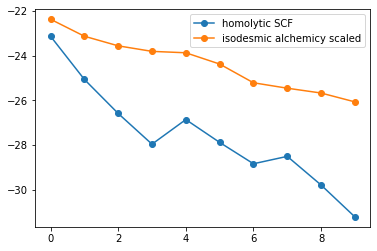

In [128]:
# do the alchemical electronic binding energies in isodesmic reaction have same trend as SCF binding energies for homolytic bond dissociation?


# electronic energy diatomics
e_dia_ele = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/diatomics/electronic_energies/e_dia_ele.txt')
# electronic energy of radicals including hydrogens
e_rad_el =  dict(zip(['C', 'N', 'O', 'F'] , [-49.468519962737474, -63.378335102918356, -80.03487167261326, -99.67399896980169]))

comps = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
ebele = []
for e, c in zip(e_dia_ele, comps):
    ebele.append(e - (e_rad_el[c[0]]+e_rad_el[c[1]]))
    
plt.plot(ebele, '-o', label = 'homolytic SCF')
plt.plot(np.array(binding_energies)*2, '-o', label = 'isodesmic alchemicy scaled')
plt.legend()

In [123]:
# code to get electronic energy of the diatomics

import os
import ase.io as aio
from ase.units import Bohr
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

from pyscf import gto, dft, scf

# geometric
from pyscf.geomopt.geometric_solver import optimize

# 



spin = 0
if spin == 0:
    path = '/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single'
    comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']

elif spin == 1:
    path = '/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/fragments_single/'
    comps = ['CC', 'NN', 'OO', 'FF']

e_dia_ele = []
for c in comps:


    atoms = aio.read(os.path.join(path, f'{c}_opt.xyz'))

    pyscf_atoms = uqm.ase2pyscf(atoms)
    basis = 'def2-tzvp'
    mol = gto.Mole()
    mol.atom = pyscf_atoms
    mol.spin = spin
    mol.basis = basis
    mol.build()

    if spin != 0:
        mf = dft.ROKS(mol)
    else:
        mf = dft.RKS(mol)
    mf.xc = 'pbe0'



    mol_eq = optimize(mf, maxsteps=100)

    new_pos = mol_eq.atom_coords()*Bohr
    atoms.set_positions(new_pos)

    pyscf_atoms = uqm.ase2pyscf(atoms)
    basis = 'def2-tzvp'
    mol = gto.Mole()
    mol.atom = pyscf_atoms
    mol.basis = basis
    mol.spin = spin
    mol.build()

    if spin != 0:
        mf = dft.ROKS(mol)
    else:
        mf = dft.RKS(mol)
    mf.xc = 'pbe0'
    mf.kernel()
    
    print(mf.e_tot)
    e_dia_ele.append(mf.e_tot-mol.energy_nuc())
# np.savetxt('/data/sahre/projects/atomic-energies/data/bonding_trends/diatomics/electronic_energies/e_dia_ele.txt',e_dia_ele)


                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.759176   0.007708  -0.015881    0.000000  0.000000  0.000000
   C   0.759194  -0.007717   0.015884    0.000000  0.000000  0.000000
   H  -1.180217  -0.102138   0.986421    0.000000  0.000000 -0.000000
   H  -1.139942   0.944122  -0.430724    0.000000  0.000000  0.000000
   H  -1.153596  -0.806698  -0.628356    0.000000  0.000000  0.000000
   H   1.153728   0.809611   0.624380    0.000000  0.000000  0.000000
   H   1.180194   0.097220  -0.986960    0.000000  0.000000  0.000000
   H   1.139888  -0.942146   0.435248    0.000000  0.000000  0.000000
converged SCF energy = -79.7502038166717
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 C     0.0000160184     0.0000004954     0.0000005014
1 C    -0.0000166197     0.0000002881    -0.0000005485
2 H    -0.0000049492    -0.0000167275     0.0000035285
3 H    

Step    0 : Gradient = 1.798e-05/1.928e-05 (rms/max) Energy = -79.7502038167
Hessian Eigenvalues: 2.30000e-02 5.00000e-02 5.00000e-02 ... 3.45048e-01 3.45048e-01 3.45048e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.759175   0.007688  -0.015896    0.000001 -0.000019 -0.000015
   C   0.759197  -0.007700   0.015900    0.000003  0.000017  0.000016
   H  -1.180211  -0.101938   0.986421    0.000006  0.000200  0.000000
   H  -1.139932   0.943999  -0.430956    0.000010 -0.000123 -0.000232
   H  -1.153549  -0.806861  -0.628191    0.000047 -0.000163  0.000165
   H   1.153673   0.809486   0.624605   -0.000055 -0.000125  0.000225
   H   1.180197   0.097498  -0.986906    0.000003  0.000278  0.000054
   H   1.139888  -0.942219   0.435039   -0.000000 -0.000073 -0.000209
converged SCF energy = -79.7502038615087
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 C     0.0000058640     0.0000002615     0.0000003559
1 C    -0.0000060451    -0.0000001421    -0.0000003328
2 H    -0.0000006561    -0.0000145188    -0.0000011697
3 H    

Step    1 : Displace = 2.097e-04/2.422e-04 (rms/max) Trust = 1.000e-01 (=) Grad = 1.365e-05/1.615e-05 (rms/max) E (change) = -79.7502038615 (-4.484e-08) Quality = 1.856
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 4.450 seconds


converged SCF energy = -79.7502038615218
-79.75020386152177



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.567955  -0.008812  -0.010995    0.000000  0.000000  0.000000
   N   0.840124   0.188314   0.289474    0.000000  0.000000 -0.000000
   H  -1.049117  -0.517658   0.827327    0.000000  0.000000 -0.000000
   H  -0.778697  -0.589176  -0.921144    0.000000  0.000000  0.000000
   H  -1.055345   0.963186  -0.115467    0.000000  0.000000  0.000000
   H   1.308111  -0.701744   0.402230    0.000000  0.000000  0.000000
   H   1.303306   0.666607  -0.472512    0.000000  0.000000  0.000000
converged SCF energy = -95.7772908820019
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 C    -0.0000544824    -0.0000178959    -0.0000271025
1 N     0.0000375228     0.0000367802     0.0000443800
2 H     0.0000037321    -0.0000037519     0.0000043728
3 H     0.0000221622     0.0000082811     0.0000046144
4 H     0.0000024342  

Step    0 : Gradient = 3.971e-05/6.878e-05 (rms/max) Energy = -95.7772908820
Hessian Eigenvalues: 2.30000e-02 5.00000e-02 5.00000e-02 ... 3.78272e-01 4.56568e-01 4.56573e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.567940  -0.008835  -0.011053    0.000014 -0.000022 -0.000058
   N   0.840120   0.188298   0.289309   -0.000004 -0.000016 -0.000164
   H  -1.049076  -0.517595   0.827330    0.000041  0.000063  0.000003
   H  -0.778931  -0.589247  -0.921137   -0.000234 -0.000071  0.000007
   H  -1.055330   0.963158  -0.115549    0.000016 -0.000029 -0.000082
   H   1.308313  -0.701620   0.402139    0.000201  0.000125 -0.000091
   H   1.303385   0.666795  -0.472470    0.000079  0.000188  0.000042
converged SCF energy = -95.7772908995913
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 C    -0.0000379428    -0.0000109812    -0.0000138617
1 N     0.0000242260     0.0000235647     0.0000252160
2 H     0.0000020509    -0.0000021565    -0.0000022409
3 H     0.0000031621     0.0000057263     0.0000014155
4 H     0.0000013029  

Step    1 : Displace = 1.487e-04/2.436e-04 (rms/max) Trust = 1.000e-01 (=) Grad = 2.368e-05/4.217e-05 (rms/max) E (change) = -95.7772908996 (-1.759e-08) Quality = 0.900
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 4.017 seconds


converged SCF energy = -95.7772908996445
-95.77729089964447



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.354264   0.026996  -0.020953    0.000000  0.000000  0.000000
   O   0.924789  -0.498935  -0.291222    0.000000  0.000000  0.000000
   H  -0.621763  -0.049317   1.040311    0.000000  0.000000  0.000000
   H  -0.449823   1.074604  -0.332490    0.000000  0.000000  0.000000
   H  -1.070118  -0.563202  -0.593845    0.000000  0.000000  0.000000
   H   1.572636   0.007154   0.202965    0.000000  0.000000  0.000000
converged SCF energy = -115.637261842516
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 C    -0.0000854727     0.0000234342     0.0000059689
1 O     0.0000410618    -0.0000145729    -0.0000291891
2 H     0.0000209517    -0.0000064738    -0.0000015760
3 H     0.0000133541     0.0000003370    -0.0000002157
4 H     0.0000038624     0.0000020421    -0.0000009168
5 H    -0.0000013539     0.0000096617

Step    0 : Gradient = 4.362e-05/8.883e-05 (rms/max) Energy = -115.6372618425
Hessian Eigenvalues: 2.30000e-02 5.00000e-02 5.00000e-02 ... 3.47658e-01 4.41415e-01 5.56472e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.354123   0.026865  -0.020747    0.000142 -0.000131  0.000207
   O   0.924900  -0.499187  -0.290649    0.000111 -0.000253  0.000573
   H  -0.622028  -0.049285   1.040433   -0.000265  0.000032  0.000122
   H  -0.449684   1.074433  -0.332439    0.000139 -0.000171  0.000051
   H  -1.069877  -0.563361  -0.593746    0.000241 -0.000159  0.000099
   H   1.572751   0.006920   0.203497    0.000115 -0.000234  0.000532
converged SCF energy = -115.637261859483
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 C    -0.0000323405     0.0000174096     0.0000076261
1 O     0.0000231866    -0.0000057350    -0.0000234461
2 H     0.0000055045    -0.0000030324    -0.0000039287
3 H    -0.0000024847     0.0000006930     0.0000014969
4 H     0.0000023916     0.0000029111    -0.0000007271
5 H    -0.0000036485     0.0000021914

Step    1 : Displace = 8.286e-05/1.174e-04 (rms/max) Trust = 1.000e-01 (=) Grad = 2.106e-05/3.751e-05 (rms/max) E (change) = -115.6372618595 (-1.697e-08) Quality = 0.641
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 3.573 seconds


converged SCF energy = -115.637261859665
-115.63726185966499



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.061495  -0.006399  -0.005029    0.000000  0.000000  0.000000
   F   1.303060   0.127755   0.110367    0.000000  0.000000 -0.000000
   H  -0.489854  -0.167247   0.986902    0.000000  0.000000  0.000000
   H  -0.474316   0.904769  -0.443960    0.000000  0.000000  0.000000
   H  -0.283385  -0.861241  -0.647914    0.000000  0.000000  0.000000
converged SCF energy = -139.653810125277
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 C     0.0002409773     0.0000241762     0.0000194147
1 F    -0.0001736280    -0.0000105565    -0.0000185447
2 H    -0.0000071872    -0.0000007972     0.0000110775
3 H    -0.0000151752     0.0000111829    -0.0000062900
4 H    -0.0000051518    -0.0000088115    -0.0000080083
----------------------------------------------
cycle 1: E = -139.653810125  dE = -139.654  norm(grad) = 0.0

Step    0 : Gradient = 1.344e-04/2.430e-04 (rms/max) Energy = -139.6538101253
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 3.45391e-01 3.45392e-01 4.98444e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -0.062010  -0.006560  -0.005017   -0.000515 -0.000162  0.000012
   F   1.302746   0.127427   0.110505   -0.000314 -0.000328  0.000138
   H  -0.490379  -0.167361   0.986890   -0.000525 -0.000114 -0.000013
   H  -0.474576   0.904685  -0.443959   -0.000260 -0.000084  0.000001
   H  -0.283878  -0.861357  -0.647928   -0.000493 -0.000115 -0.000014
converged SCF energy = -139.653810189158
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 C     0.0001051621     0.0000117278     0.0000079345
1 F    -0.0000502254     0.0000021689    -0.0000081179
2 H    -0.0000026140     0.0000002733     0.0000024505
3 H    -0.0000094676     0.0000026446    -0.0000021325
4 H    -0.0000029086    -0.0000017625    -0.0000023926
----------------------------------------------
cycle 2: E = -139.653810189  dE = -6.3881e-08  norm(grad) = 

Step    1 : Displace = 6.164e-05/1.001e-04 (rms/max) Trust = 1.000e-01 (=) Grad = 5.289e-05/1.061e-04 (rms/max) E (change) = -139.6538101892 (-6.388e-08) Quality = 1.089
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 3.177 seconds


converged SCF energy = -139.653810189166
-139.65381018916568



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.685213   0.174605  -0.220995    0.000000  0.000000  0.000000
   N   0.684205  -0.181528  -0.218057    0.000000  0.000000  0.000000
   H  -1.225518  -0.647712  -0.451924    0.000000  0.000000  0.000000
   H  -1.001994   0.522004   0.677726    0.000000  0.000000  0.000000
   H   1.004574  -0.500230   0.689983    0.000000  0.000000  0.000000
   H   1.223539   0.633000  -0.477142    0.000000  0.000000  0.000000
converged SCF energy = -111.784922082555
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 N     0.0000970560    -0.0000762553    -0.0000121370
1 N    -0.0000967745     0.0000768806    -0.0000167718
2 H    -0.0000412502    -0.0000338696    -0.0000333208
3 H    -0.0000200756     0.0000580386     0.0000466337
4 H     0.0000209047    -0.0000579814     0.0000515913
5 H     0.0000402752     0.0000320418

Step    0 : Gradient = 9.238e-05/1.247e-04 (rms/max) Energy = -111.7849220826
Hessian Eigenvalues: 2.30000e-02 5.00000e-02 5.00000e-02 ... 4.52656e-01 4.58597e-01 4.58599e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.685199   0.174793  -0.221120    0.000014  0.000187 -0.000124
   N   0.684187  -0.181692  -0.218175   -0.000018 -0.000164 -0.000117
   H  -1.225402  -0.647567  -0.451851    0.000116  0.000145  0.000073
   H  -1.001763   0.521775   0.677750    0.000231 -0.000229  0.000024
   H   1.004336  -0.499981   0.689995   -0.000237  0.000249  0.000012
   H   1.223426   0.632885  -0.477050   -0.000113 -0.000115  0.000092
converged SCF energy = -111.784922174858
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 N     0.0000693966    -0.0000479634     0.0000148945
1 N    -0.0000692558     0.0000480225     0.0000136945
2 H     0.0000127852     0.0000086022    -0.0000013885
3 H     0.0000075389     0.0000121718    -0.0000128575
4 H    -0.0000075070    -0.0000125855    -0.0000122556
5 H    -0.0000128219    -0.0000093967

Step    1 : Displace = 2.534e-04/3.462e-04 (rms/max) Trust = 1.000e-01 (=) Grad = 5.141e-05/8.566e-05 (rms/max) E (change) = -111.7849221749 (-9.230e-08) Quality = 1.228
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 3.552 seconds


converged SCF energy = -111.784922175093
-111.78492217509306



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.531123  -0.001750   0.339355    0.000000  0.000000  0.000000
   O   0.869745  -0.105520   0.460951   -0.000000  0.000000  0.000000
   H  -0.745493   0.887522  -0.103387    0.000000  0.000000  0.000000
   H  -0.851288  -0.744450  -0.276016    0.000000  0.000000  0.000000
   H   1.256749  -0.036619  -0.420164    0.000000  0.000000  0.000000
converged SCF energy = -131.622414421478
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 N     0.0000898898     0.0000007738     0.0000367442
1 O    -0.0000899717    -0.0000012538    -0.0000247089
2 H     0.0000014760     0.0000175708    -0.0000119474
3 H     0.0000023644    -0.0000217017    -0.0000103576
4 H     0.0000027243     0.0000084350     0.0000070970
----------------------------------------------
cycle 1: E = -131.622414421  dE = -131.622  norm(grad) = 0.0

Step    0 : Gradient = 6.214e-05/9.711e-05 (rms/max) Energy = -131.6224144215
Hessian Eigenvalues: 2.30000e-02 5.00000e-02 5.00000e-02 ... 4.49398e-01 4.49406e-01 5.44488e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.531215  -0.001768   0.339351   -0.000092 -0.000018 -0.000004
   O   0.869757  -0.105535   0.461021    0.000012 -0.000015  0.000070
   H  -0.745626   0.887508  -0.103309   -0.000133 -0.000014  0.000078
   H  -0.851420  -0.744401  -0.276036   -0.000132  0.000049 -0.000020
   H   1.256750  -0.036823  -0.420120    0.000002 -0.000204  0.000044
converged SCF energy = -131.622414437628
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 N     0.0000311837     0.0000045816     0.0000010631
1 O    -0.0000112162    -0.0000043335    -0.0000030554
2 H    -0.0000111781    -0.0000011332    -0.0000041736
3 H    -0.0000083822    -0.0000011431    -0.0000001789
4 H     0.0000060778     0.0000058637     0.0000031617
----------------------------------------------
cycle 2: E = -131.622414438  dE = -1.61506e-08  norm(grad) =

Step    1 : Displace = 9.964e-05/1.223e-04 (rms/max) Trust = 1.000e-01 (=) Grad = 1.700e-05/3.154e-05 (rms/max) E (change) = -131.6224144376 (-1.615e-08) Quality = 1.129
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 3.096 seconds


converged SCF energy = -131.622414437741
-131.62241443774116



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.139062   0.009512   0.353946    0.000000  0.000000  0.000000
   F   1.193365  -0.054550  -0.096943    0.000000  0.000000  0.000000
   H  -0.564612  -0.784995  -0.123350    0.000000  0.000000  0.000000
   H  -0.488745   0.836366  -0.129952    0.000000  0.000000  0.000000
converged SCF energy = -155.625693632422
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 N     0.0001044685    -0.0000101249     0.0000107303
1 F    -0.0000695004    -0.0000189642     0.0000003907
2 H    -0.0000329463    -0.0000385195    -0.0000159571
3 H    -0.0000111839     0.0000364176    -0.0000190990
----------------------------------------------
cycle 1: E = -155.625693632  dE = -155.626  norm(grad) = 0.00014478


Step    0 : Gradient = 7.239e-05/1.055e-04 (rms/max) Energy = -155.6256936324
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 4.43028e-01 4.43580e-01 4.43598e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.139146   0.009771   0.354153   -0.000084  0.000259  0.000207
   F   1.193567  -0.053659  -0.096241    0.000202  0.000891  0.000702
   H  -0.564098  -0.784874  -0.123329    0.000514  0.000121  0.000021
   H  -0.488990   0.836416  -0.129869   -0.000244  0.000050  0.000083
converged SCF energy = -155.62569366466
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 N     0.0000304403    -0.0000072991    -0.0000123641
1 F    -0.0000196282    -0.0000213464    -0.0000151878
2 H    -0.0000192276     0.0000009299     0.0000029010
3 H    -0.0000004429    -0.0000040032    -0.0000002077
----------------------------------------------
cycle 2: E = -155.625693665  dE = -3.2238e-08  norm(grad) = 5.09864e-05


Step    1 : Displace = 4.789e-05/5.371e-05 (rms/max) Trust = 1.000e-01 (=) Grad = 2.549e-05/3.366e-05 (rms/max) E (change) = -155.6256936647 (-3.224e-08) Quality = 0.581
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 2.715 seconds


converged SCF energy = -155.625693664667
-155.62569366466724



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.550619   0.461589  -0.001428    0.000000  0.000000  0.000000
   O   0.550623  -0.461591   0.002104    0.000000  0.000000  0.000000
   H  -1.280656  -0.166850  -0.000064    0.000000  0.000000  0.000000
   H   1.280653   0.166851  -0.000608    0.000000  0.000000  0.000000
converged SCF energy = -151.453106283989
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.0000014421     0.0000044458    -0.0000036651
1 O     0.0000001539    -0.0000047322    -0.0000049228
2 H    -0.0000032960     0.0000066774     0.0000042399
3 H     0.0000016966    -0.0000063857     0.0000042913
----------------------------------------------
cycle 1: E = -151.453106284  dE = -151.453  norm(grad) = 1.47454e-05


Step    0 : Gradient = 7.373e-06/8.569e-06 (rms/max) Energy = -151.4531062840
Hessian Eigenvalues: 2.30000e-02 5.00000e-02 5.00000e-02 ... 3.99979e-01 5.47757e-01 5.47759e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.550721   0.461469  -0.001354   -0.000102 -0.000120  0.000074
   O   0.550721  -0.461466   0.002190    0.000097  0.000125  0.000086
   H  -1.280608  -0.167142  -0.000149    0.000048 -0.000292 -0.000086
   H   1.280610   0.167138  -0.000680   -0.000043  0.000286 -0.000072
converged SCF energy = -151.453106296842
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O     0.0000023295     0.0000050380    -0.0000047003
1 O    -0.0000019986    -0.0000050177    -0.0000059057
2 H    -0.0000004224     0.0000060629     0.0000052401
3 H     0.0000000866    -0.0000060782     0.0000052951
----------------------------------------------
cycle 2: E = -151.453106297  dE = -1.28529e-08  norm(grad) = 1.56951e-05


Step    1 : Displace = 7.980e-05/8.022e-05 (rms/max) Trust = 1.000e-01 (=) Grad = 7.848e-06/8.062e-06 (rms/max) E (change) = -151.4531062968 (-1.285e-08) Quality = 2.051
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 2.397 seconds


converged SCF energy = -151.45310629687
-151.45310629686958



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.208750   0.480506   0.000000    0.000000  0.000000  0.000000
   F   1.018612  -0.206308   0.000000    0.000000  0.000000  0.000000
   H  -0.809182  -0.280224   0.000000    0.000000  0.000000  0.000000
converged SCF energy = -175.439418837766
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O    -0.0000422527     0.0000052498    -0.0000000000
1 F     0.0000321288     0.0000537870     0.0000000000
2 H     0.0000128457     0.0000064737     0.0000000000
----------------------------------------------
cycle 1: E = -175.439418838  dE = -175.439  norm(grad) = 7.71043e-05


Step    0 : Gradient = 4.452e-05/6.265e-05 (rms/max) Energy = -175.4394188378
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 1.60000e-01 4.45664e-01 5.35534e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   O  -0.208194   0.480089   0.000000    0.000556 -0.000417  0.000000
   F   1.018292  -0.208232  -0.000000   -0.000321 -0.001924 -0.000000
   H  -0.809504  -0.279963   0.000000   -0.000322  0.000261  0.000000
converged SCF energy = -175.439418994079
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 O    -0.0000173579     0.0000203439     0.0000000000
1 F     0.0000056402     0.0000583253     0.0000000000
2 H     0.0000165226    -0.0000129606    -0.0000000000
----------------------------------------------
cycle 2: E = -175.439418994  dE = -1.56313e-07  norm(grad) = 6.77481e-05


Step    1 : Displace = 4.016e-05/4.663e-05 (rms/max) Trust = 1.000e-01 (=) Grad = 3.911e-05/5.860e-05 (rms/max) E (change) = -175.4394189941 (-1.563e-07) Quality = 1.166
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 2.277 seconds


converged SCF energy = -175.439418994057
-175.43941899405732



                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .))))))  
          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  
        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 
      #%      %%      .%%%%%%/      *%%


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   F   0.687825   0.000000   0.000000    0.000000  0.000000  0.000000
   F  -0.687825   0.000000   0.000000    0.000000  0.000000  0.000000
converged SCF energy = -199.408534947505
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 F    -0.0000002085     0.0000000000    -0.0000000000
1 F     0.0000002085    -0.0000000000     0.0000000000
----------------------------------------------
cycle 1: E = -199.408534948  dE = -199.409  norm(grad) = 2.9489e-07


Step    0 : Gradient = 2.085e-07/2.085e-07 (rms/max) Energy = -199.4085349475
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 5.00000e-02



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   F   0.687827  -0.000000   0.000000    0.000002 -0.000000  0.000000
   F  -0.687827   0.000000  -0.000000   -0.000002  0.000000 -0.000000
converged SCF energy = -199.408534947409
--------------- SCF_Scanner gradients ---------------
         x                y                z
0 F     0.0000031457    -0.0000000000     0.0000000000
1 F    -0.0000031457     0.0000000000    -0.0000000000
----------------------------------------------
cycle 2: E = -199.408534947  dE = 9.68043e-11  norm(grad) = 4.44868e-06


Step    1 : Displace = 2.207e-06/2.207e-06 (rms/max) Trust = 1.000e-01 (=) Grad = 3.146e-06/3.146e-06 (rms/max) E (change) = -199.4085349474 (+9.680e-11) Quality = -111.321
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 1.558 seconds


converged SCF energy = -199.408534947409
-199.40853494740895


In [ ]:
# hydrogen contributions

In [39]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies')
import utils_qm as uqm

import numpy as np
from matplotlib import pyplot as plt

In [40]:
def read_energies(path):
    with open(path, 'r') as f:
        energies = []
        # header
        f.readline()
        for line in f:
            energies.append(float(line.split()[-1]))
    return(energies)

# fragment
def H_frag(path):
    energies = read_energies(path)

    return(energies[1:])

def H_diatomic(path, smiles, heavy):
    energies = read_energies(path)
    num_h = uqm.hcount_smiles(smiles)
    if heavy == 'A':
        return(energies[2:2+num_h[0]])
    elif heavy == 'B':
        return(energies[2+num_h[0]:])
    

In [41]:
e_H2 = (-1.029154884995695962e+00+-1.029154960269883290e+00)/2

In [42]:
path_frag = '/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/sat_frags/C/atomic_energies_sat_frag.txt'
C_frag = np.array(H_frag(path_frag)).sum()
frag_dict = dict()
for s in ['C', 'N', 'O', 'F']:
    path_frag = f'/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/sat_frags/{s}/atomic_energies_sat_frag.txt'
    frag_dict[s] = np.array(H_frag(path_frag)).sum()

In [43]:
uqm.fragmentize_smiles('CN')

['C', 'N']

In [44]:
smiles = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']

bH = dict()
bH_el = {'C':[], 'N':[], 'O':[], 'F':[]}

for s in smiles:
    path_dia = f'/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/diatomics/{s}/atomic_energies.txt'
    EA = np.array(H_diatomic(path_dia, s, 'A')).sum()
    EB = np.array(H_diatomic(path_dia, s, 'B')).sum()
    
    fnA, fnB = uqm.fragmentize_smiles(s)
    
    bEA = EA + e_H2 - frag_dict[fnA]
    bEB = EB + e_H2 - frag_dict[fnB]
    bH[s] = [bEA, bEB]
    
    if fnA == fnB:
        bH_el[fnA].append(bEA)
    else:
        bH_el[fnA].append(bEA)
        bH_el[fnB].append(bEB)

#     CHbB.append(().sum()+e_H2-C_frag))

In [45]:
frag_dict_heavy = dict()
for s in ['C', 'N', 'O', 'F']:
    path_frag = f'/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/sat_frags/{s}/atomic_energies_sat_frag.txt'
    frag_dict_heavy[s] = read_energies(path_frag)[0]

In [46]:
smiles = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']

bAB = dict()
bAB_el = {'C':[], 'N':[], 'O':[], 'F':[]}

for s in smiles:
    path_dia = f'/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/diatomics/{s}/atomic_energies.txt'
    EA = read_energies(path_dia)[0]
    EB = read_energies(path_dia)[1]
    
    fnA, fnB = uqm.fragmentize_smiles(s)
    
    bEA = EA - frag_dict_heavy[fnA]
    bEB = EB - frag_dict_heavy[fnB]
    bAB[s] = [bEA, bEB]
    
    if fnA == fnB:
        bAB_el[fnA].append(bEA)
    else:
        bAB_el[fnA].append(bEA)
        bAB_el[fnB].append(bEB)

In [61]:
# percentage = dict()
# for k in bH.keys():
#     percentage[k[0]] += bH[k][0]
    

In [54]:
bH

{'CC': [-1.2679834154591187, -1.2676631079366327],
 'CN': [-1.3581224649540697, -0.27626277568835444],
 'CO': [-1.4798462164323727, 0.8120765274006052],
 'CF': [-1.5141131386829425, 1.8543098039989487],
 'NN': [-0.29297678299955443, -0.29970556103650203],
 'NO': [-0.3657662259583656, 0.7959643714236275],
 'NF': [-0.46169199202925615, 1.8543098039989487],
 'OO': [0.7290127825953574, 0.7289803553791634],
 'OF': [0.6983727480344459, 1.8543098039989487],
 'FF': [1.8543098039989487, 1.8543098039989487]}

In [55]:
bAB

{'CC': [-4.326763687539184, -4.326712071703781],
 'CN': [-4.594258873734599, -5.340208895567731],
 'CO': [-4.8166024151985845, -6.299490810645267],
 'CF': [-4.988687810322606, -7.2589384669378845],
 'NN': [-5.671557424668009, -5.674806989466795],
 'NO': [-5.916951443340125, -6.70403028174929],
 'NF': [-6.17889724694496, -7.823486858291226],
 'OO': [-7.094596236877869, -7.09473087012535],
 'OF': [-7.256926987327951, -8.134868399613097],
 'FF': [-8.372725265609901, -8.373234897735806]}

In [62]:
binding_energies2 = []
for k in bH.keys():
    binding_energies2.append(bH[k][0]+bH[k][1]+bAB[k][0]+bAB[k][1])

In [63]:
binding_energies2

[-11.189122282638717,
 -11.568853009944753,
 -11.78386291487562,
 -11.907429611944483,
 -11.93904675817086,
 -12.190783579624153,
 -12.609766293266492,
 -12.731333969028698,
 -12.839112834907652,
 -13.037340555347809]

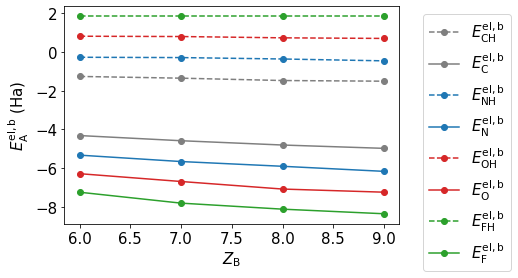

In [53]:
plt.rcParams['font.size'] = 15
for k, c in zip(bH_el.keys(),['gray', 'blue', 'red', 'green']):
#     plt.plot([6,7,8,9], bH_el[k]-bH_el[k][0]+bAB_el[k][0], '-o', label = k)
    
#     el = 'C'
    label_H = r'$E^{\rm{el, b}}_{\rm{'+ k + 'H}}$'
    label_A = r'$E^{\rm{el, b}}_{\rm{'+ k + '}}$'
    
    plt.plot([6,7,8,9], bH_el[k], '--o', color = f'tab:{c}', label = label_H)
    plt.plot([6,7,8,9], bAB_el[k], '-o', color = f'tab:{c}', label = label_A)
plt.xlabel(r'$Z_{\rm{B}}$')
plt.ylabel(r'$E_{\rm{A}}^{\rm{el, b}}$ (Ha)')
plt.legend(bbox_to_anchor = (1.05, 1))
plt.savefig('/home/sahre/work/bonding_trends/figures/alch_bind_en.png', bbox_inches = 'tight')

In [34]:
print(s)

$E^{\rm{el, b}}_{\rm{C}}$


In [58]:
bH

{'CC': [-1.2679834154591187, -1.2676631079366327],
 'CN': [-1.3581224649540697, -0.27626277568835444],
 'CO': [-1.4798462164323727, 0.8120765274006052],
 'CF': [-1.5141131386829425, 1.8543098039989487],
 'NN': [-0.29297678299955443, -0.29970556103650203],
 'NO': [-0.3657662259583656, 0.7959643714236275],
 'NF': [-0.46169199202925615, 1.8543098039989487],
 'OO': [0.7290127825953574, 0.7289803553791634],
 'OF': [0.6983727480344459, 1.8543098039989487],
 'FF': [1.8543098039989487, 1.8543098039989487]}

In [59]:
1.2679834154591187/4.326763687539184

0.2930558512152706

In [54]:
-4.326763687539184--4.594258873734599

0.2674951861954149

In [56]:
-1.2679834154591187--1.3581224649540697

0.090139049494951

In [57]:
0.090139049494951/0.2674951861954149

0.33697447336155484

In [55]:
bH_el

{'C': [-1.2679834154591187,
  -1.3581224649540697,
  -1.4798462164323727,
  -1.5141131386829425],
 'N': [-0.27626277568835444,
  -0.29297678299955443,
  -0.3657662259583656,
  -0.46169199202925615],
 'O': [0.8120765274006052,
  0.7959643714236275,
  0.7290127825953574,
  0.6983727480344459],
 'F': [1.8543098039989487,
  1.8543098039989487,
  1.8543098039989487,
  1.8543098039989487]}